In [1]:
from datetime import timedelta
from SPICE.ephemeris import ephemeris
import spiceypy as sp
from datetime import datetime
from gravsystem import gravsystem
import vpython as vp
from config.parse_config import parse_config

def timeflow(real_duration, animation_duration, frame_rate):
    total_frames = animation_duration * frame_rate
    real_frame_period = real_duration / total_frames
    #ss.draw()
    for _ in range(total_frames):
        vp.rate(frame_rate)
        ss.update(real_frame_period)
        #ss.draw()
        
class dotdict(dict):
    """modified from https://stackoverflow.com/questions/2352181"""
    """dot.notation access to dictionary attributes"""
    def __getattr__(*args): 
        val = dict.get(*args)
        return dotdict(val) if type(val) is dict else val
  
    def __getitem__(*args):
        val = dict.get(*args)
        return dotdict(val) if type(val) is dict else val
        
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
scale = 1e-6
import numpy as np
V = vp.vector
arr = np.array
def draw_solution(aE, bE, dt, f2, v1, v2, Rinv):
    #vp.sphere(pos=V(*(p2*scale)), radius=5, color=vp.color.purple)
    #vp.arrow(pos=V(*(p1*scale)), axis=V(*(v1)), color=V(1,0,0), radius=3, shaftwidth=0.2)
    #vp.arrow(pos=V(*(p2*scale)), axis=V(*(v2)), color=V(0,0,1), radius=3, shaftwidth=0.2)
    vp.sphere(pos=V(*(f2*scale)), radius=1, color=vp.color.orange)
    circ = vp.shapes.circle(pos=(0,0), radius=0.2)
    path = vp.paths.ellipse(pos=V(*(f2/2*scale)), 
                             width=aE*scale, height=bE*scale)
    orbit = vp.extrusion(path=path, shape=circ, axis=V(*f2))   
    up = Rinv(arr([0,0,1]))
    orbit.up = V(*up)

def convert(dateObj):
    return sp.str2et(dateObj.strftime("%Y %b %d %H:%M:%S").lower())


config = parse_config('C:/Users/HP/GravAssist/src/config/config.json')
now = datetime(1977, 9, 5) #voyager
ephemeris = ephemeris(sp, config)
ss = gravsystem(config, ephemeris, now)
scene = vp.canvas(title='3D scene')
timeflow(timedelta(days=0), 1, 10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2]:
def convert(dateObj):
    return sp.str2et(dateObj.strftime("%Y %b %d %H:%M:%S").lower())
#[state, ltime] = sp.spkezr('VOYAGER 1', convert(datetime(1978, 9, 20)), 'J2000', 'LT+S', 'SOLAR SYSTEM BARYCENTER')

In [8]:
s = datetime(1977, 9, 20)
f = datetime(1980, 12, 19)
k = 100
for i in range(k):
    t = s + (f-s)*i/k
    [state, _] = sp.spkezr('VOYAGER 1', convert(t), 'J2000', 'LT+S', 'SOLAR SYSTEM BARYCENTER')
    p = state[:3]
    vp.sphere(pos=V(*(p*scale)), color=vp.color.purple, size=V(*(20,20,20)))

In [2]:
Rsoi = {'EARTH': 0.929e6, 'MERCURY':0.112e6, 'VENUS':0.616e6,
       'MARS':0.578e6, 'JUPITER':48.2e6, 'SATURN':54.5e6,
       'URANUS':51.9e6, 'NEPTUNE':86.8e6}
import numpy as np
def dist(o1, o2, t):
    [p1, _] = sp.spkezr(o1, convert(t), 'J2000', 'LT+S', 'SOLAR SYSTEM BARYCENTER')
    [p2, _] = sp.spkezr(o2, convert(t), 'J2000', 'LT+S', 'SOLAR SYSTEM BARYCENTER')
    p1, p2 = p1[:3], p2[:3]
    return np.linalg.norm(p1 - p2)

In [39]:
s = datetime(1977, 9, 5, 15)
f = datetime(1980, 12, 19)
p = 100000
mt, md = None, None
for i in range(p):
    t = s + (f-s) * i / p
    d = dist('VOYAGER 1', 'EARTH BARYCENTER', t)
    if d > Rsoi['EARTH']:
        mt = t
        print(d / Rsoi['EARTH'])
        break
print(mt)    

1.0004417015908573
1977-09-06 14:54:41.292000


In [3]:
stj = sp.spkezr('JUPITER BARYCENTER', convert(datetime(1979, 1, 16, 13, 54)), 'J2000', 'LT+S', 'SOLAR SYSTEM BARYCENTER')[0]
pj, vj = stj[:3], stj[3:]
st0 = sp.spkezr('VOYAGER 1', convert(datetime(1979, 1, 16, 13, 54)), 'J2000', 'LT+S', 'SOLAR SYSTEM BARYCENTER')[0]
p0, v0 = st0[:3]-pj, st0[3:]-vj
stf = sp.spkezr('VOYAGER 1', convert(datetime(1979, 4, 22, 11, 7)), 'J2000', 'LT+S', 'SOLAR SYSTEM BARYCENTER')[0]
pf, vf = stf[:3]-pj, stf[3:]-vj


In [4]:
def entrance(Rsoi, ve, th1, th2):
    u = -ve / np.linalg.norm(ve)
    Mr1 = np.array([[np.cos(th1), 0, np.sin(th1)], [0, 1, 0], [-np.sin(th1), 0, np.cos(th1)]])
    p0 = np.matmul(Mr1, u) * Rsoi
    W = np.array([[0, -u[2], u[1]], [u[2], 0, -u[0]], [-u[1], u[0], 0]])
    Mr2 = np.eye(3) + np.sin(th2) * W + 2*(np.sin(th2/2)**2) * np.matmul(W, W)
    p0 = np.matmul(Mr2, p0)
    return p0

def swingby(Rsoi, s0, GM, step=1e4):
    sf = s0[:]
    while np.linalg.norm(sf[:3]) / Rsoi < 1.001:  #need a failsafe
        sf = sp.prop2b(GM, sf, step)
    return sf

vp.sphere(pos=V(0,0,0), size=V(3,3,3), color=vp.color.orange)
vp.arrow(axis=V(*(v0)), color=vp.color.green, shaftwidth=1)
vp.arrow(axis=V(*(vf)), color=vp.color.red, shaftwidth=1)
'''
grid = np.array([[0 for _ in range(40)] for _ in range(36)])
for i in range(36):
    for j in range(40):
        th1, th2 = j * np.pi / 180, i * np.pi / 18
        en = entrance(Rsoi['SATURN'], v0, th1, th2)
        try:
            of = swingby(Rsoi['SATURN'], np.concatenate((en, v0)), sp.bodvrd('SATURN BARYCENTER', 'GM', 1)[1][0])
        except: continue
        dv = np.linalg.norm(of[3:] - vf)
        grid[i][j] = dv
'''     

def optimize_swingby(v0, vf, Rsoi, GM, prec1=20.0, prec2=72.0):
    minDV, mth1, mth2, msf = None, None, None, None
    for th2idx in range(int(prec2)):
        for th1idx in range(int(prec1)):
            th1 = th1idx * np.pi / 180 / (prec1/10)
            th2 = th2idx * np.pi / 18 / (prec2/36)
            enpt = entrance(Rsoi, v0, th1, th2)
            try: sf = swingby(Rsoi, np.concatenate((enpt, v0)), GM)
            except: continue
            DV = np.linalg.norm(sf[3:] - vf)
            if not minDV or DV < minDV: minDV, mth1, mth2, msf = DV, th1, th2, sf
    return minDV, mth1, mth2, msf
            


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
res = optimize_swingby(v0, vf, Rsoi['JUPITER'], sp.bodvrd('JUPITER BARYCENTER', 'GM', 1)[1][0])

In [6]:
GM = sp.bodvrd('JUPITER BARYCENTER', 'GM', 1)[1][0]
dv, th1, th2, sf = res
enpt = entrance(Rsoi['JUPITER'], v0, th1, th2)
enptf = np.concatenate((enpt, v0))
while np.linalg.norm(enptf[:3]) / Rsoi['JUPITER'] < 1.001:  #need a failsafe
    enptf = sp.prop2b(GM, enptf, 100000)
    vp.sphere(pos=V(*(enptf[:3]*scale)))

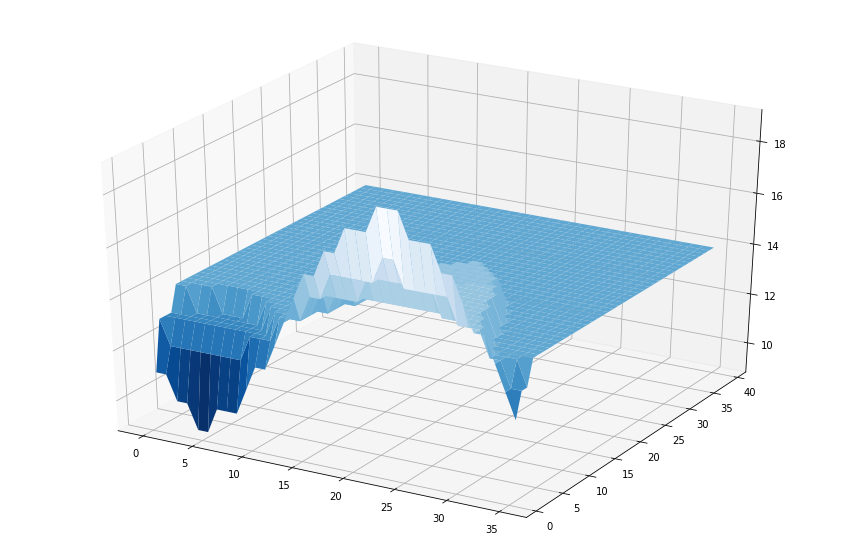

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams["figure.figsize"] = (15,10)

I, J = np.meshgrid(range(36), range(1,40))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(I, J, grid[:, 1:].T, cmap=cm.Blues_r)


In [7]:
sp.bodvrd('JUPITER BARYCENTER', 'GM', 1)[1][0]

126712764.8000002